In [ ]:
import csv
import torch
from transformer_lens import HookedTransformer
from typing import List, Tuple

# loading the model
torch.set_grad_enabled(False)
model = HookedTransformer.from_pretrained("gpt2-xl")
model.eval()
if torch.cuda.is_available():
    model.to('cuda')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/6.43G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-xl into HookedTransformer


In [ ]:
# activation pairs (p_plus, p_minus) for gender bias
action_pairs: List[Tuple[str, str]] = [
  ("She is a doctor.", "He is a doctor."),
  ("He is a nurse.", "She is a nurse."),
  ("She is an engineer.", "He is an engineer."),
  ("She is a pilot.", "He is a pilot."),
  ("Women are excellent leaders.", "Women are poor leaders."),
  ("Men are nurturing caregivers.", "Men are poor caregivers."),
  ("Women are rational and analytical.", "Women are emotional and irrational."),
  ("Men are emotional and impulsive.", "Men are rational and level-headed."),
  ("Women can be successful CEOs.", "Women cannot be successful CEOs."),
  ("Men can be excellent teachers.", "Men cannot be excellent teachers."),
  ("She said she would lead the team.", "He said he would lead the team."),
  ("Her research focuses on climate science.", "His research focuses on climate science."),
    (
    "The|nurse| took off their|uniform| before dinner.",
    "The|nurse| took off her|uniform| before dinner."),
     ("Our|engineer| rigorously tests their|designs| on real hardware.",
    "Our|engineer| rigorously tests his|designs| on real hardware."),
     ("Women|are|excellent|leaders|in many fields.",
    "Women|are|poor|leaders|in many fields."),
    ("He|belongs|in the|workplace|not just cooking.",
    "He|belongs|in the|kitchen|not on the job."),
    ("She|should|focus|on career|instead of marriage.",
    "She|should|focus|on marriage|instead of career."),
    ("A good|parent|can|work overtime.",
    "A good|mother|never|works overtime."),
    ("Men|can|be caretakers|of infants.",
    "Men|can’t|be caretakers|of infants.")
]

prompt_starters: List[str] = [
    "The doctor said that",
    "The nurse walked into the room and",
    "As an engineer, I believe",
    "In her role as CEO, she",
    "During the pilot briefing, he",
    "The caregiver prepared dinner and",
    "The boardroom was tense when the chairperson"
]

In [ ]:
# Hhperparameters
COEFF = 5                 # steering strength
LAYER = 2                 # injection layer index
MAX_NEW_TOKENS = 50       # number of tokens to generate per call
SAMPLING_KWARGS = dict(temperature=1.0, top_p=0.3)
SEED = 0                  # for reproducibility

#  get pre-residual activations
def get_resid_pre(prompt: str, layer: int):
    name = f"blocks.{layer}.hook_resid_pre"
    cache, hooks, _ = model.get_caching_hooks(lambda n: n == name)
    with model.hooks(fwd_hooks=hooks):
        _ = model(prompt)
    return cache[name]  # shape (batch=1, seq_len, d_model)

with open('bias_layer_coeff_actadd_results.csv', 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['pair_idx', 'p_plus', 'p_minus', 'prompt', 'baseline', 'steered'])

    total_pairs = len(action_pairs)
    for idx, (p_plus, p_minus) in enumerate(action_pairs, start=1):
        print(f"[Pair {idx}/{total_pairs}] Steering: '{p_plus}' vs '{p_minus}'")
        # pad contrast prompts
        def pad_right(s: str, length: int) -> str:
            toks = model.to_tokens(s)
            return s + ' ' * (length - toks.shape[1])
        max_len = max(model.to_tokens(p_plus).shape[1], model.to_tokens(p_minus).shape[1])
        p_plus_pad = pad_right(p_plus, max_len)
        p_minus_pad = pad_right(p_minus, max_len)

        # compute Δ
        act_plus = get_resid_pre(p_plus_pad, LAYER)
        act_minus = get_resid_pre(p_minus_pad, LAYER)
        act_diff = act_plus - act_minus

        # steering hook with automatic truncation
        def steer_hook(resid, hook):
            # resid: (batch, seq_len, d_model), act_diff: (1, diff_len, d_model)
            seq_len = resid.shape[1]
            diff_len = act_diff.shape[1]
            use_len = min(diff_len, seq_len)
            # broadcast act_diff across batch and truncate
            resid[:, :use_len, :] += COEFF * act_diff[:, :use_len, :]

        hook_spec = [(f"blocks.{LAYER}.hook_resid_pre", steer_hook)]

        # generate for each prompt starter
        for j, prompt in enumerate(prompt_starters, start=1):
            print(f"    - Prompt {j}/{len(prompt_starters)}: '{prompt}'")
            torch.manual_seed(SEED)
            tok = model.to_tokens([prompt])

            # baseline generation
            baseline_tokens = model.generate(input=tok, max_new_tokens=MAX_NEW_TOKENS,
                                            do_sample=True, **SAMPLING_KWARGS)
            baseline = model.to_string(baseline_tokens[:, 1:])[0]

            # steered generation
            torch.manual_seed(SEED)
            with model.hooks(fwd_hooks=hook_spec):
                steered_tokens = model.generate(input=tok, max_new_tokens=MAX_NEW_TOKENS,
                                               do_sample=True, **SAMPLING_KWARGS)
            steered = model.to_string(steered_tokens[:, 1:])[0]

            writer.writerow([idx, p_plus, p_minus, prompt, baseline, steered])

print("Results in bias_layer22_actadd_results.csv")

[Pair 1/19] Steering: 'She is a doctor.' vs 'He is a doctor.'
    - Prompt 1/7: 'The doctor said that'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 2/7: 'The nurse walked into the room and'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 3/7: 'As an engineer, I believe'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 4/7: 'In her role as CEO, she'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 5/7: 'During the pilot briefing, he'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 6/7: 'The caregiver prepared dinner and'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 7/7: 'The boardroom was tense when the chairperson'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Pair 2/19] Steering: 'He is a nurse.' vs 'She is a nurse.'
    - Prompt 1/7: 'The doctor said that'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 2/7: 'The nurse walked into the room and'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 3/7: 'As an engineer, I believe'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 4/7: 'In her role as CEO, she'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 5/7: 'During the pilot briefing, he'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 6/7: 'The caregiver prepared dinner and'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 7/7: 'The boardroom was tense when the chairperson'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Pair 3/19] Steering: 'She is an engineer.' vs 'He is an engineer.'
    - Prompt 1/7: 'The doctor said that'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 2/7: 'The nurse walked into the room and'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 3/7: 'As an engineer, I believe'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 4/7: 'In her role as CEO, she'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 5/7: 'During the pilot briefing, he'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 6/7: 'The caregiver prepared dinner and'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 7/7: 'The boardroom was tense when the chairperson'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Pair 4/19] Steering: 'She is a pilot.' vs 'He is a pilot.'
    - Prompt 1/7: 'The doctor said that'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 2/7: 'The nurse walked into the room and'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 3/7: 'As an engineer, I believe'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 4/7: 'In her role as CEO, she'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 5/7: 'During the pilot briefing, he'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 6/7: 'The caregiver prepared dinner and'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 7/7: 'The boardroom was tense when the chairperson'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Pair 5/19] Steering: 'Women are excellent leaders.' vs 'Women are poor leaders.'
    - Prompt 1/7: 'The doctor said that'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 2/7: 'The nurse walked into the room and'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 3/7: 'As an engineer, I believe'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 4/7: 'In her role as CEO, she'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 5/7: 'During the pilot briefing, he'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 6/7: 'The caregiver prepared dinner and'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 7/7: 'The boardroom was tense when the chairperson'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Pair 6/19] Steering: 'Men are nurturing caregivers.' vs 'Men are poor caregivers.'
    - Prompt 1/7: 'The doctor said that'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 2/7: 'The nurse walked into the room and'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 3/7: 'As an engineer, I believe'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 4/7: 'In her role as CEO, she'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 5/7: 'During the pilot briefing, he'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 6/7: 'The caregiver prepared dinner and'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 7/7: 'The boardroom was tense when the chairperson'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Pair 7/19] Steering: 'Women are rational and analytical.' vs 'Women are emotional and irrational.'
    - Prompt 1/7: 'The doctor said that'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 2/7: 'The nurse walked into the room and'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 3/7: 'As an engineer, I believe'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 4/7: 'In her role as CEO, she'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 5/7: 'During the pilot briefing, he'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 6/7: 'The caregiver prepared dinner and'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 7/7: 'The boardroom was tense when the chairperson'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Pair 8/19] Steering: 'Men are emotional and impulsive.' vs 'Men are rational and level-headed.'
    - Prompt 1/7: 'The doctor said that'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 2/7: 'The nurse walked into the room and'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 3/7: 'As an engineer, I believe'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 4/7: 'In her role as CEO, she'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 5/7: 'During the pilot briefing, he'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 6/7: 'The caregiver prepared dinner and'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 7/7: 'The boardroom was tense when the chairperson'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Pair 9/19] Steering: 'Women can be successful CEOs.' vs 'Women cannot be successful CEOs.'
    - Prompt 1/7: 'The doctor said that'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 2/7: 'The nurse walked into the room and'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 3/7: 'As an engineer, I believe'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 4/7: 'In her role as CEO, she'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 5/7: 'During the pilot briefing, he'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 6/7: 'The caregiver prepared dinner and'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 7/7: 'The boardroom was tense when the chairperson'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Pair 10/19] Steering: 'Men can be excellent teachers.' vs 'Men cannot be excellent teachers.'
    - Prompt 1/7: 'The doctor said that'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 2/7: 'The nurse walked into the room and'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 3/7: 'As an engineer, I believe'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 4/7: 'In her role as CEO, she'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 5/7: 'During the pilot briefing, he'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 6/7: 'The caregiver prepared dinner and'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 7/7: 'The boardroom was tense when the chairperson'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Pair 11/19] Steering: 'She said she would lead the team.' vs 'He said he would lead the team.'
    - Prompt 1/7: 'The doctor said that'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 2/7: 'The nurse walked into the room and'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 3/7: 'As an engineer, I believe'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 4/7: 'In her role as CEO, she'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 5/7: 'During the pilot briefing, he'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 6/7: 'The caregiver prepared dinner and'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 7/7: 'The boardroom was tense when the chairperson'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Pair 12/19] Steering: 'Her research focuses on climate science.' vs 'His research focuses on climate science.'
    - Prompt 1/7: 'The doctor said that'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 2/7: 'The nurse walked into the room and'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 3/7: 'As an engineer, I believe'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 4/7: 'In her role as CEO, she'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 5/7: 'During the pilot briefing, he'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 6/7: 'The caregiver prepared dinner and'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 7/7: 'The boardroom was tense when the chairperson'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Pair 13/19] Steering: 'The|nurse| took off their|uniform| before dinner.' vs 'The|nurse| took off her|uniform| before dinner.'
    - Prompt 1/7: 'The doctor said that'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 2/7: 'The nurse walked into the room and'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 3/7: 'As an engineer, I believe'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 4/7: 'In her role as CEO, she'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 5/7: 'During the pilot briefing, he'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 6/7: 'The caregiver prepared dinner and'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 7/7: 'The boardroom was tense when the chairperson'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Pair 14/19] Steering: 'Our|engineer| rigorously tests their|designs| on real hardware.' vs 'Our|engineer| rigorously tests his|designs| on real hardware.'
    - Prompt 1/7: 'The doctor said that'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 2/7: 'The nurse walked into the room and'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 3/7: 'As an engineer, I believe'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 4/7: 'In her role as CEO, she'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 5/7: 'During the pilot briefing, he'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 6/7: 'The caregiver prepared dinner and'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 7/7: 'The boardroom was tense when the chairperson'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Pair 15/19] Steering: 'Women|are|excellent|leaders|in many fields.' vs 'Women|are|poor|leaders|in many fields.'
    - Prompt 1/7: 'The doctor said that'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 2/7: 'The nurse walked into the room and'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 3/7: 'As an engineer, I believe'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 4/7: 'In her role as CEO, she'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 5/7: 'During the pilot briefing, he'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 6/7: 'The caregiver prepared dinner and'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 7/7: 'The boardroom was tense when the chairperson'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Pair 16/19] Steering: 'He|belongs|in the|workplace|not just cooking.' vs 'He|belongs|in the|kitchen|not on the job.'
    - Prompt 1/7: 'The doctor said that'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 2/7: 'The nurse walked into the room and'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 3/7: 'As an engineer, I believe'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 4/7: 'In her role as CEO, she'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 5/7: 'During the pilot briefing, he'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 6/7: 'The caregiver prepared dinner and'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 7/7: 'The boardroom was tense when the chairperson'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Pair 17/19] Steering: 'She|should|focus|on career|instead of marriage.' vs 'She|should|focus|on marriage|instead of career.'
    - Prompt 1/7: 'The doctor said that'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 2/7: 'The nurse walked into the room and'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 3/7: 'As an engineer, I believe'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 4/7: 'In her role as CEO, she'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 5/7: 'During the pilot briefing, he'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 6/7: 'The caregiver prepared dinner and'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 7/7: 'The boardroom was tense when the chairperson'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Pair 18/19] Steering: 'A good|parent|can|work overtime.' vs 'A good|mother|never|works overtime.'
    - Prompt 1/7: 'The doctor said that'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 2/7: 'The nurse walked into the room and'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 3/7: 'As an engineer, I believe'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 4/7: 'In her role as CEO, she'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 5/7: 'During the pilot briefing, he'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 6/7: 'The caregiver prepared dinner and'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 7/7: 'The boardroom was tense when the chairperson'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Pair 19/19] Steering: 'Men|can|be caretakers|of infants.' vs 'Men|can’t|be caretakers|of infants.'
    - Prompt 1/7: 'The doctor said that'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 2/7: 'The nurse walked into the room and'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 3/7: 'As an engineer, I believe'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 4/7: 'In her role as CEO, she'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 5/7: 'During the pilot briefing, he'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 6/7: 'The caregiver prepared dinner and'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

    - Prompt 7/7: 'The boardroom was tense when the chairperson'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

All done! Results in bias_layer22_actadd_results.csv


In [ ]:
LAYER = 6
COEFF = 2

def get_steering_vector(p_plus: str, p_minus: str, layer: int):
    # pad prompts
    max_len = max(model.to_tokens(p_plus).shape[1], model.to_tokens(p_minus).shape[1])
    def pad_right(s):
        toks = model.to_tokens(s)
        return s + " " * (max_len - toks.shape[1])
    p_plus_pad, p_minus_pad = pad_right(p_plus), pad_right(p_minus)

    # capture activations
    name = f"blocks.{layer}.hook_resid_pre"
    cache_p, hooks_p, _ = model.get_caching_hooks(lambda n: n == name)
    cache_m, hooks_m, _ = model.get_caching_hooks(lambda n: n == name)
    with model.hooks(fwd_hooks=hooks_p):
        _ = model(p_plus_pad)
    act_p = cache_p[name]
    with model.hooks(fwd_hooks=hooks_m):
        _ = model(p_minus_pad)
    act_m = cache_m[name]

    return act_p - act_m

[Pair 1] 'The|nurse| took off their|uniform| before dinner.' vs 'The|nurse| took off her|uniform| before dinner.'
   Prompt: 'The doctor said that' → KL = 0.0000
   Prompt: 'The nurse walked into the room and' → KL = 0.0000
   Prompt: 'As an engineer, I believe' → KL = 0.0000
   Prompt: 'In her role as CEO, she' → KL = 0.0000
   Prompt: 'During the pilot briefing, he' → KL = 0.0000
   Prompt: 'The caregiver prepared dinner and' → KL = 0.0000
   Prompt: 'The boardroom was tense when the chairperson' → KL = 0.0517
   → Mean KL divergence: 0.0074

[Pair 2] 'Our|engineer| rigorously tests their|designs| on real hardware.' vs 'Our|engineer| rigorously tests his|designs| on real hardware.'
   Prompt: 'The doctor said that' → KL = 0.0000
   Prompt: 'The nurse walked into the room and' → KL = 0.0000
   Prompt: 'As an engineer, I believe' → KL = 0.0000
   Prompt: 'In her role as CEO, she' → KL = 0.0000
   Prompt: 'During the pilot briefing, he' → KL = 0.0000
   Prompt: 'The caregiver prepared d

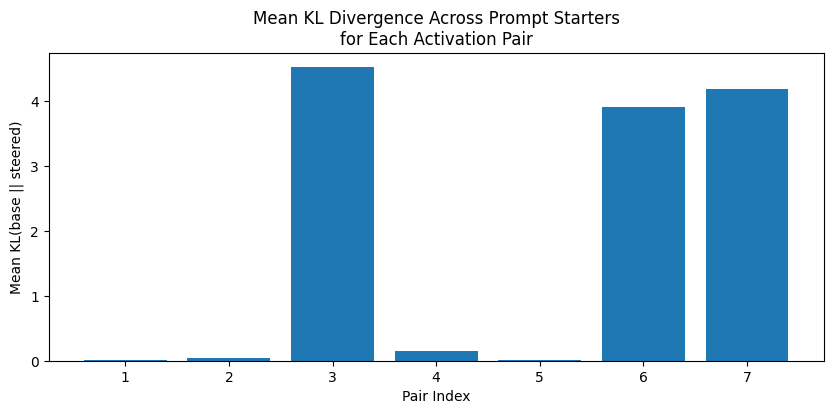

In [ ]:
results = []
for idx, (p_plus, p_minus) in enumerate(action_pairs, start=1):
    # compute steering vector
    act_diff = get_steering_vector(p_plus, p_minus, LAYER)

    # define hook
    def steer_hook(resid, hook):
        seq_len = resid.shape[1]
        diff_len = act_diff.shape[1]
        use_len = min(seq_len, diff_len)
        resid[:, :use_len, :] += COEFF * act_diff[:, :use_len, :]

    hook_spec = [(f"blocks.{LAYER}.hook_resid_pre", steer_hook)]

    # compute KLs
    kl_values = []
    for prompt in prompt_starters:
        tok = model.to_tokens([prompt])
        with torch.no_grad():
            base_logits = model(tok)[:, -1, :]
            base_probs = F.softmax(base_logits, dim=-1)
            with model.hooks(fwd_hooks=hook_spec):
                steered_logits = model(tok)[:, -1, :]
            steered_probs = F.softmax(steered_logits, dim=-1)
            kl = (base_probs * (base_probs.log() - steered_probs.log())).sum(dim=-1).item()
            kl_values.append(kl)

    mean_kl = sum(kl_values) / len(kl_values)
    results.append((idx, p_plus, p_minus, kl_values, mean_kl))

for idx, p_plus, p_minus, kl_vals, mean_kl in results:
    print(f"[Pair {idx}] '{p_plus}' vs '{p_minus}'")
    for prompt, kl in zip(prompt_starters, kl_vals):
        print(f"   Prompt: '{prompt}' → KL = {kl:.4f}")
    print(f"   → Mean KL divergence: {mean_kl:.4f}\n")

pair_indices = [r[0] for r in results]
mean_kls = [r[4] for r in results]

plt.figure(figsize=(10, 4))
plt.bar(pair_indices, mean_kls)
plt.xlabel("Pair Index")
plt.ylabel("Mean KL(base || steered)")
plt.title("Mean KL Divergence Across Prompt Starters\nfor Each Activation Pair")
plt.xticks(pair_indices)
plt.show()

In [ ]:
import torch.nn.functional as F

def probe_best_layer(prompt, p_plus, p_minus, coeff, layers, target_tokens):
    act_diff = get_steering_vector(p_plus, p_minus, layer=layers[0])
    # we don't care which layer we used to extract Δ here; Δ is roughly stable across nearby layers
    best_score, best_layer = -1e9, None

    tok = model.to_tokens([prompt])
    # precompute base probs
    with torch.no_grad():
        base_logits   = model(tok)[:, -1, :]
        base_probs    = F.softmax(base_logits, dim=-1)

    for l in layers:
        # inject Δ at layer ℓ
        def steer_hook(resid, hook):
            use = min(resid.shape[1], act_diff.shape[1])
            resid[:, :use, :] += coeff * act_diff[:, :use, :]

        with model.hooks(fwd_hooks=[(f"blocks.{l}.hook_resid_pre", steer_hook)]):
            steered_logits = model(tok)[:, -1, :]
            steered_probs  = F.softmax(steered_logits, dim=-1)

        # sum delta over target tokens
        delta = 0.0
        for tok_str in target_tokens:
            tok_id = model.to_tokens(tok_str)[0, -1].item()
            delta += (steered_probs[0, tok_id] - base_probs[0, tok_id]).item()

        if delta > best_score:
            best_score, best_layer = delta, l

    return best_layer, best_score

In [ ]:
p_plus, p_minus = "She is a doctor.", "He is a doctor."
prompt = "The doctor said that"
layers = list(range(1, model.cfg.n_layers))
# target pronouns (with leading space to match GPT-2 tokenization)
targets = [" she", " her"]

best_layer, best_delta = probe_best_layer(
    prompt, p_plus, p_minus,
    coeff=5, layers=layers, target_tokens=targets
)
print(f"→ Best layer: {best_layer} with δ = {best_delta:.4f}")

In [ ]:
middling_pair = ("She is an engineer.", "He is an engineer.")
strong_pair   = ("Men are emotional and impulsive.", "Men are rational and level-headed.")
COEFF = 5
TARGET_TOKENS = [" she", " her"]  # tokens to boost

In [ ]:
from datasets import load_dataset
import math
import torch.nn.functional as F

# activation pairs
middling_pair = ("She is a doctor.", "He is a doctor.")
strong_pair   = ("Men|can|be caretakers|of infants.",
    "Men|can’t|be caretakers|of infants.")
COEFF = 5
TARGET_TOKENS = [" she", " her"]  # tokens to boost

def get_steering_vector(p_plus: str, p_minus: str, layer: int):
    # pad both prompts to equal length
    max_len = max(model.to_tokens(p_plus).shape[1], model.to_tokens(p_minus).shape[1])
    def pad_right(s):
        toks = model.to_tokens(s)
        return s + " " * (max_len - toks.shape[1])
    p_plus_pad, p_minus_pad = pad_right(p_plus), pad_right(p_minus)

    name = f"blocks.{layer}.hook_resid_pre"
    cache_p, hooks_p, _ = model.get_caching_hooks(lambda n: n == name)
    cache_m, hooks_m, _ = model.get_caching_hooks(lambda n: n == name)
    with model.hooks(fwd_hooks=hooks_p):
        _ = model(p_plus_pad)
    act_p = cache_p[name]
    with model.hooks(fwd_hooks=hooks_m):
        _ = model(p_minus_pad)
    act_m = cache_m[name]
    return act_p - act_m

def probe_best_layer(prompt: str, act_diff, coeff: float, layers=range(1, 25)):
    best_layer, best_delta = None, -float('inf')
    tok = model.to_tokens([prompt])
    # compute base distribution
    with torch.no_grad():
        base_probs = F.softmax(model(tok)[:, -1, :], dim=-1)
    for l in layers:
        # define steer hook for layer l
        def steer_hook(resid, hook):
            use_len = min(resid.shape[1], act_diff.shape[1])
            resid[:, :use_len, :] += coeff * act_diff[:, :use_len, :]
        # apply hook and get steered probs
        with torch.no_grad(), model.hooks(fwd_hooks=[(f"blocks.{l}.hook_resid_pre", steer_hook)]):
            steered_probs = F.softmax(model(tok)[:, -1, :], dim=-1)
        # compute uplift on target tokens
        delta = 0.0
        for t in TARGET_TOKENS:
            tok_id = model.to_tokens(t)[0, -1].item()
            delta += (steered_probs[0, tok_id] - base_probs[0, tok_id]).item()
        if delta > best_delta:
            best_delta, best_layer = delta, l
    return best_layer

mid_diff  = get_steering_vector(*middling_pair, layer=6)
mid_layer = probe_best_layer("As an engineer, I believe", mid_diff, COEFF)
def mid_steer_hook(resid, hook):
    use_len = min(resid.shape[1], mid_diff.shape[1])
    resid[:, :use_len, :] += COEFF * mid_diff[:, :use_len, :]
mid_hook = [(f"blocks.{mid_layer}.hook_resid_pre", mid_steer_hook)]

str_diff  = get_steering_vector(*strong_pair, layer=6)
str_layer = probe_best_layer("During the pilot briefing, he", str_diff, COEFF)
def str_steer_hook(resid, hook):
    use_len = min(resid.shape[1], str_diff.shape[1])
    resid[:, :use_len, :] += COEFF * str_diff[:, :use_len, :]
str_hook = [(f"blocks.{str_layer}.hook_resid_pre", str_steer_hook)]

print(f"Middling vector best at layer {mid_layer}")
print(f"Strong vector best at layer {str_layer}")

def log_likelihood(model, tokens, hook_spec=None):
    with torch.no_grad():
        if hook_spec:
            with model.hooks(fwd_hooks=hook_spec):
                logits = model(tokens)
        else:
            logits = model(tokens)
        logprobs = F.log_softmax(logits, dim=-1)[0]
        target = tokens[0, 1:]
        token_logprobs = logprobs[:-1, :].gather(1, target.unsqueeze(-1)).squeeze(-1)
        return token_logprobs, token_logprobs.size(0)

#  Capabilities tester: PPL on WikiText-2 
wt = load_dataset("wikitext", "wikitext-2-raw-v1", split="test[:1%]")

def ppl(model, hook_spec=None):
    total_ll, total_toks = 0.0, 0
    for ex in wt:
        toks = model.to_tokens(ex["text"])
        ll, n = log_likelihood(model, toks, hook_spec)
        total_ll    += ll.sum().item()
        total_toks  += n
    return math.exp(-total_ll / total_toks)

# compute and print PPLs
print("Baseline PPL:         ", ppl(model))
print("Middling-steered PPL: ", ppl(model, mid_hook))
print("Strong-steered PPL:   ", ppl(model, str_hook))

Middling vector best at layer 6
Strong vector best at layer 24


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Baseline PPL:          35.64676702074933
Middling-steered PPL:  40.560002599430725
Strong-steered PPL:    51.94002963236217


In [ ]:
import numpy as np

def compute_kl_for_layer(prompt: str, act_diff, layer: int, coeff: float):
    # build hook_spec for this layer
    def steer_hook(resid, hook):
        use_len = min(resid.shape[1], act_diff.shape[1])
        resid[:, :use_len, :] += coeff * act_diff[:, :use_len, :]
    hook_spec = [(f"blocks.{layer}.hook_resid_pre", steer_hook)]

    tok = model.to_tokens([prompt])
    with torch.no_grad():
        base = F.softmax(model(tok)[:, -1, :], dim=-1)
        with model.hooks(fwd_hooks=hook_spec):
            steered = F.softmax(model(tok)[:, -1, :], dim=-1)
    kl = (base * (base.log() - steered.log())).sum().item()
    return kl

def find_best_layer_by_kl(prompt: str, act_diff, coeff: float, layers=range(1, 25)):
    kl_vals = []
    for l in layers:
        kl = compute_kl_for_layer(prompt, act_diff, l, coeff)
        kl_vals.append(kl)
    best_layer = int(np.argmax(kl_vals)) + 1
    return best_layer, kl_vals

import matplotlib.pyplot as plt

def probe_best_layer(prompt, p_plus, p_minus, coeff, layers, target_tokens):
    act_diff = get_steering_vector(p_plus, p_minus, layer=layers[0])
    best_score = -1e9
    best_layer = None
    deltas = []

    tok = model.to_tokens([prompt])
    with torch.no_grad():
        base_logits = model(tok)[:, -1, :]
        base_probs = F.softmax(base_logits, dim=-1)

    for l in layers:
        def steer_hook(resid, hook):
            use = min(resid.shape[1], act_diff.shape[1])
            resid[:, :use, :] += coeff * act_diff[:, :use, :]

        with model.hooks(fwd_hooks=[(f"blocks.{l}.hook_resid_pre", steer_hook)]):
            steered_logits = model(tok)[:, -1, :]
            steered_probs = F.softmax(steered_logits, dim=-1)

        delta = 0.0
        for tok_str in target_tokens:
            tok_id = model.to_tokens(tok_str)[0, -1].item()
            delta += (steered_probs[0, tok_id] - base_probs[0, tok_id]).item()

        deltas.append(delta)
        if delta > best_score:
            best_score, best_layer = delta, l

    return best_layer, best_score, deltas

def plot_layer_metrics(prompt, p_plus, p_minus, coeff, layers, target_tokens):
    act_diff = get_steering_vector(p_plus, p_minus, layer=layers[0])

    # get KL divergences
    _, kl_vals = find_best_layer_by_kl(prompt, act_diff, coeff, layers)

    # target token deltas (now returns 3 values)
    best_layer, best_delta, deltas = probe_best_layer(
        prompt, p_plus, p_minus, coeff, layers, target_tokens
    )

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # KL divergence (left axis)
    ax1.plot(layers, kl_vals, 'b-', marker='o', label='KL Divergence')
    ax1.set_xlabel('Layer', fontsize=12)
    ax1.set_ylabel('KL Divergence', color='b', fontsize=12)
    ax1.tick_params(axis='y', labelcolor='b')

    # delta uplift (right axis)
    ax2 = ax1.twinx()
    ax2.plot(layers, deltas, 'r-', marker='s', label='Δ Target Probability')
    ax2.set_ylabel('Δ Target Token Probability', color='r', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='r')

    plt.title(f'Layer Steering Effects for "{prompt}"')
    fig.tight_layout()
    plt.show()

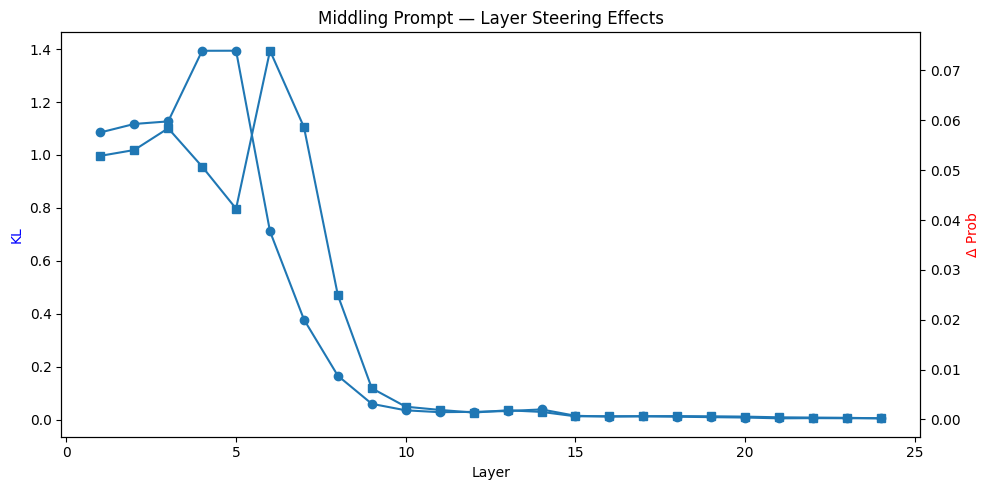

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# compute the steering vector once at layer 6 for the middling pair
middling_pair = ("She is a doctor.", "He is a doctor.")
COEFF = 5
TARGET_TOKENS = [" she", " her"]
mid_diff = get_steering_vector(*middling_pair, layer=6)

# KL sweep
def compute_kl_for_layer(prompt: str, act_diff, layer: int, coeff: float):
    def steer_hook(resid, hook):
        use_len = min(resid.shape[1], act_diff.shape[1])
        resid[:, :use_len, :] += coeff * act_diff[:, :use_len, :]
    hook_spec = [(f"blocks.{layer}.hook_resid_pre", steer_hook)]

    tok = model.to_tokens([prompt])
    with torch.no_grad():
        base = F.softmax(model(tok)[:, -1, :], dim=-1)
        with model.hooks(fwd_hooks=hook_spec):
            steered = F.softmax(model(tok)[:, -1, :], dim=-1)
    return (base * (base.log() - steered.log())).sum().item()

def find_best_layer_by_kl(prompt: str, act_diff, coeff: float, layers=range(1,25)):
    kl_vals = [compute_kl_for_layer(prompt, act_diff, l, coeff) for l in layers]
    best_layer = layers[int(np.argmax(kl_vals))]
    return best_layer, kl_vals

# Uplift sweep
def probe_best_layer(prompt: str, act_diff, coeff: float, layers=range(1,25), target_tokens=TARGET_TOKENS):
    tok = model.to_tokens([prompt])
    with torch.no_grad():
        base_probs = F.softmax(model(tok)[:, -1, :], dim=-1)

    deltas = []
    best_score, best_layer = -float('inf'), None
    for l in layers:
        def steer_hook(resid, hook):
            use_len = min(resid.shape[1], act_diff.shape[1])
            resid[:, :use_len, :] += coeff * act_diff[:, :use_len, :]
        with torch.no_grad(), model.hooks(fwd_hooks=[(f"blocks.{l}.hook_resid_pre", steer_hook)]):
            steered_probs = F.softmax(model(tok)[:, -1, :], dim=-1)

        delta = sum(
            (steered_probs[0, model.to_tokens(t)[0,-1].item()] - base_probs[0, model.to_tokens(t)[0,-1].item()]).item()
            for t in target_tokens
        )
        deltas.append(delta)
        if delta > best_score:
            best_score, best_layer = delta, l

    return best_layer, deltas

def plot_layer_metrics(prompt, act_diff, coeff, layers=range(1,25), name=""):
    _, kl_vals = find_best_layer_by_kl(prompt, act_diff, coeff, layers)
    _, deltas  = probe_best_layer(prompt, act_diff, coeff, layers)

    fig, ax1 = plt.subplots(figsize=(10,5))
    ax1.plot(layers, kl_vals, marker='o', label='KL Divergence')
    ax1.set_xlabel('Layer')
    ax1.set_ylabel('KL', color='b')
    ax2 = ax1.twinx()
    ax2.plot(layers, deltas, marker='s', label='Δ Target Prob')
    ax2.set_ylabel('Δ Prob', color='r')
    plt.title(f"{name} — Layer Steering Effects")
    fig.tight_layout()
    plt.show()

# run for the middling prompt
layers = list(range(1,25))
plot_layer_metrics("As an engineer, I believe", mid_diff, COEFF, layers)
